In [0]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:

In [0]:
!pip install scipy==1.0
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32

device = torch.device("cuda")

--2019-07-02 12:48:20--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2019-07-02 12:48:20 (58.2 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [0]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)


In [0]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [0]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


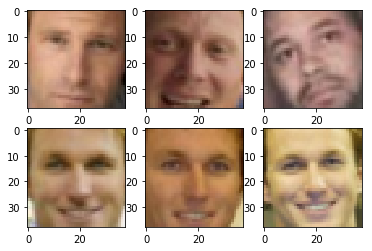

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

In [0]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [0]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super(pca_autoencoder, self).__init__()
        D_in_enc, H_enc, D_out_enc = np.prod(img_shape), 1024, code_size
        
        self.enc = torch.nn.Sequential(
          View(-1, np.prod(img_shape)),
          torch.nn.Linear(D_in_enc, H_enc),
          torch.nn.ReLU(),
          torch.nn.Linear(H_enc, D_out_enc),   
        ).to(device)
        
        self.dec = torch.nn.Sequential(
          torch.nn.Linear(D_out_enc, H_enc),
          torch.nn.ReLU(),
          torch.nn.Linear(H_enc, D_in_enc),
          View(-1, img_shape[0], img_shape[1], img_shape[2])
        ).to(device)

    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)

In [0]:
def train(model, dataset, num_epoch=32):
    model.double()
    model.to(device)
    gd = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        print(epoch)
        for i, (batch) in enumerate(dataloader):
            gd.zero_grad()
            loss = model.batch_loss(batch.cuda())
            (loss).backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [0]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    print(img.shape)
    code = model.enc(img[None].cuda())
    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))
   
    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()

In [0]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, 10)

0
#1, Train loss: 0.0290247
1
#2, Train loss: 0.0204709
2
#3, Train loss: 0.0170459
3
#4, Train loss: 0.0150796
4
#5, Train loss: 0.0137703
5
#6, Train loss: 0.0127950
6
#7, Train loss: 0.0120277
7
#8, Train loss: 0.0113911
8
#9, Train loss: 0.0108519
9
#10, Train loss: 0.0103958


In [0]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.cuda()).data.cpu().numpy())
print (np.mean(scores))

NameError: ignored

In [0]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)

In [0]:
class pca_autoencoder_deep(nn.Module):    
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep, self).__init__()
        D_in_enc, H_enc, D_out_enc = np.prod(img_shape), 1024, code_size
        
        self.enc = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
         
            
            torch.nn.Conv2d(32, 64, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2, 1),
           
            View(-1, np.prod(64 * 10 * 10)),
            torch.nn.Linear(64 * 10 * 10, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, code_size),
        ).to(device)

        self.dec = torch.nn.Sequential(
            torch.nn.Linear(code_size, 1024), 
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 10 * 10 * 64),
            torch.nn.ReLU(),
            
            View(-1, 64, 10, 10),
            torch.nn.Upsample(size = 19),
            torch.nn.ConvTranspose2d(64, 32, (3,3), stride = (1,1), padding = (1,1)),
            torch.nn.ReLU(),
            
            torch.nn.Upsample(size = 38),
            torch.nn.ConvTranspose2d(32, 3, (5,5), stride = (1,1), padding = (2,2)),   
            View(-1, img_shape[0], img_shape[1], img_shape[2])
        ).to(device)

        
  

    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        #reconstruction = self.enc(batch)
        return torch.mean((batch - reconstruction)**2)
      
    def batch_loss_noise(self, batch_noise, batch):
        reconstruction = self.dec(self.enc(batch_noise))
        return torch.mean((batch - reconstruction)**2)

In [0]:
aenc_deep = pca_autoencoder_deep()
train(aenc_deep, X_train_tensor, 5)

dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch.cuda()).data.cpu().numpy())
print (np.mean(scores))

0
#1, Train loss: 0.0228726
1
#2, Train loss: 0.0168150
2
#3, Train loss: 0.0140729
3
#4, Train loss: 0.0124279
4
#5, Train loss: 0.0112853
0.006591000242812839


0
#1, Train loss: 0.0085078
1
#2, Train loss: 0.0065449
2
#3, Train loss: 0.0058311
3
#4, Train loss: 0.0054478
4
#5, Train loss: 0.0052071
5
#6, Train loss: 0.0050331
6
#7, Train loss: 0.0049017
7
#8, Train loss: 0.0047974
8
#9, Train loss: 0.0047096
9
#10, Train loss: 0.0046359
10
#11, Train loss: 0.0045706
11
#12, Train loss: 0.0045105
12
#13, Train loss: 0.0044546
13
#14, Train loss: 0.0044014
14
#15, Train loss: 0.0043533
torch.Size([3, 38, 38])


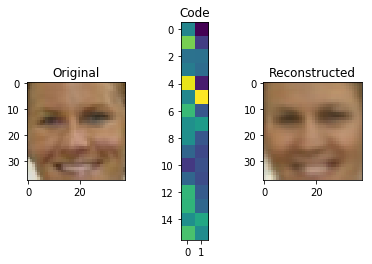

torch.Size([3, 38, 38])


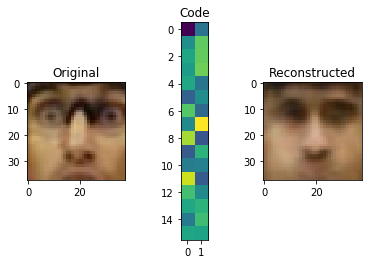

torch.Size([3, 38, 38])


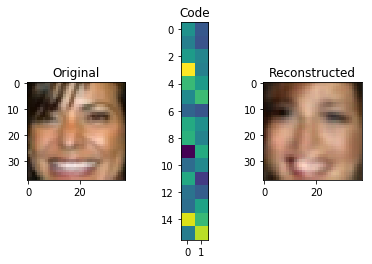

torch.Size([3, 38, 38])


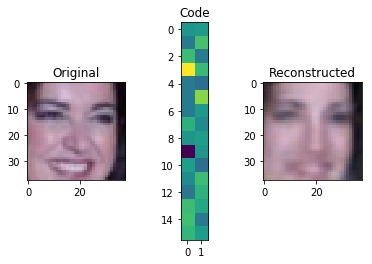

torch.Size([3, 38, 38])


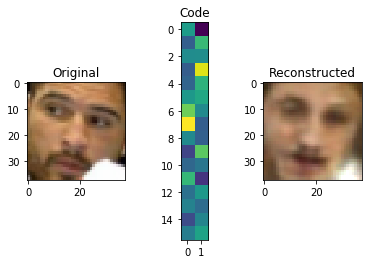

In [0]:
train(aenc_deep, X_train_tensor, 15)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

In [0]:
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = pca_autoencoder_deep(code_size).to(device)
    encoder_out = model.enc(help_tensor.type('torch.FloatTensor').cuda())
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    assert (len(list(model.dec.children())) >= 6),  "decoder must contain at least 3 dense layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


Final MSE: 0.004983888690515699
torch.Size([3, 38, 38])


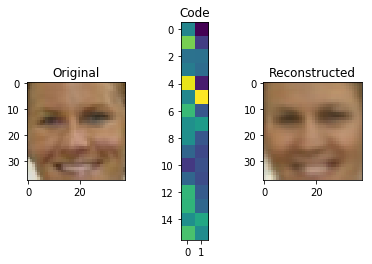

torch.Size([3, 38, 38])


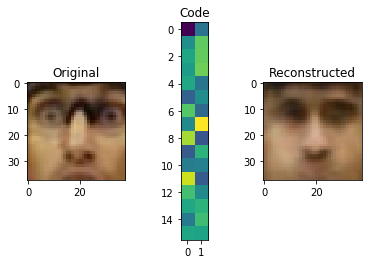

torch.Size([3, 38, 38])


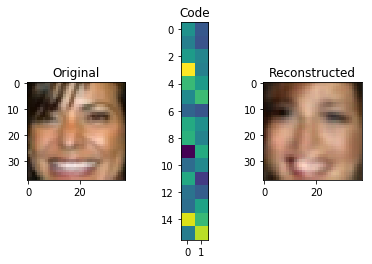

torch.Size([3, 38, 38])


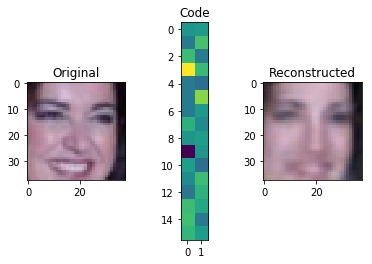

torch.Size([3, 38, 38])


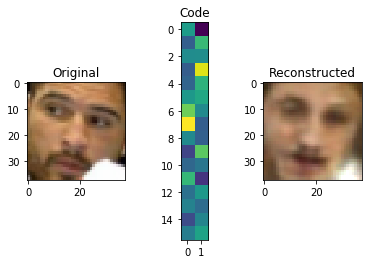

In [0]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

In [0]:
def apply_gaussian_noise(X,sigma=0.1):
    sample_x = np.random.normal(1, 0.1, 500)
    sample_y = np.random.normal(1, 0.1, 500)
    noise = np.random.normal(0, sigma, (X.shape[0], X.shape[1], X.shape[2], X.shape[3]))  
    return X + noise
  
def apply_gaussian_noise_tensor(X,sigma=0.1):
    sample_x = np.random.normal(1, 0.1, 500)
    sample_y = np.random.normal(1, 0.1, 500)
    noise = np.random.normal(0, sigma, (X.shape[0], X.shape[1], X.shape[2], X.shape[3]))  
    return X + torch.from_numpy(noise).type(torch.DoubleTensor)  

In [0]:
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

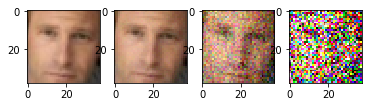

In [0]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose([1,2,0]).clip(0, 1))

In [0]:
def train_noise(model, dataset, num_epoch=50):
    model.double()
    model.to(device)
    gd = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        for i, (batch) in enumerate(dataloader):
            batch_noise = apply_gaussian_noise_tensor(batch, sigma=0.1)
            gd.zero_grad()
            loss = model.batch_loss_noise(batch_noise.cuda(), batch.cuda())
            (loss).backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [0]:
X_train_noise = X_train
X_test_noise = X_test

In [0]:
X_train_tensor_n = torch.from_numpy(X_train_noise).type(torch.DoubleTensor)
X_test_tensor_n = torch.Tensor(X_test_noise).type(torch.DoubleTensor)

In [0]:
aenc_deep_noise = pca_autoencoder_deep()
train_noise(aenc_deep_noise, X_train_tensor_n, 15)

#1, Train loss: 0.0216336
#2, Train loss: 0.0160850
#3, Train loss: 0.0136411
#4, Train loss: 0.0121555
#5, Train loss: 0.0111104
#6, Train loss: 0.0103344
#7, Train loss: 0.0097233
#8, Train loss: 0.0092304
#9, Train loss: 0.0088220
#10, Train loss: 0.0084808
#11, Train loss: 0.0081901
#12, Train loss: 0.0079390
#13, Train loss: 0.0077193
#14, Train loss: 0.0075248
#15, Train loss: 0.0073471


torch.Size([3, 38, 38])


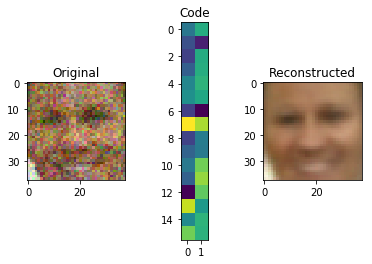

torch.Size([3, 38, 38])


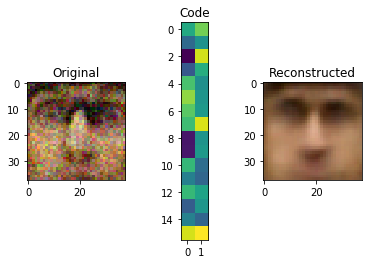

torch.Size([3, 38, 38])


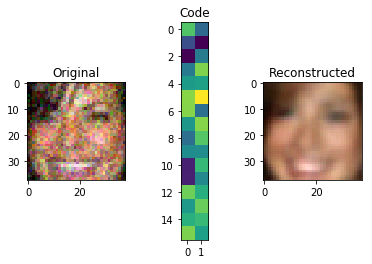

torch.Size([3, 38, 38])


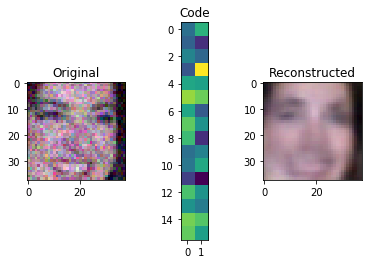

torch.Size([3, 38, 38])


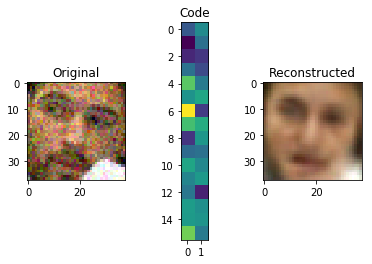

In [0]:
for i in range(5):
    img = apply_gaussian_noise_tensor(X_test_tensor_n)[i]
    visualize(img,aenc_deep_noise)

Final MSE: 0.005937828482528595
torch.Size([3, 38, 38])


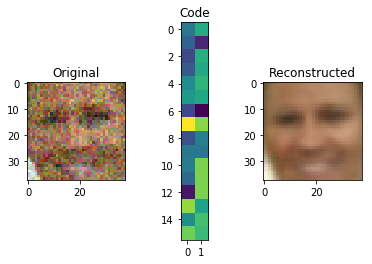

torch.Size([3, 38, 38])


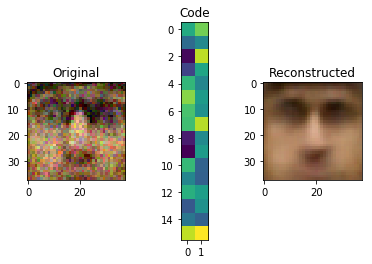

torch.Size([3, 38, 38])


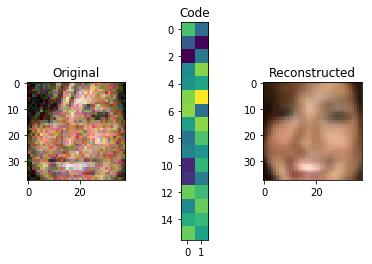

torch.Size([3, 38, 38])


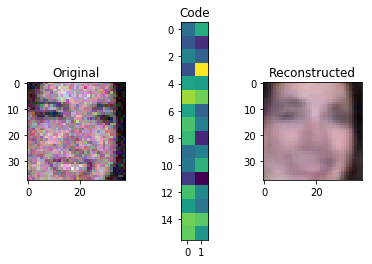

torch.Size([3, 38, 38])


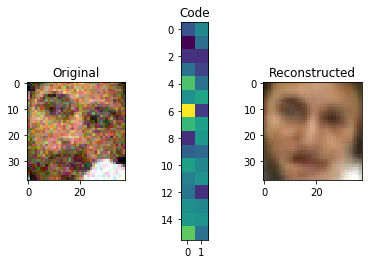

In [0]:
dataloader_test = DataLoader(X_test_tensor_n, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep_noise.batch_loss(batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_deep_noise.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise_tensor(X_test_tensor_n)[i]
    visualize(img,aenc_deep_noise)

In [0]:
train(aenc_deep, X_train_tensor, 20)
dataloader_test = DataLoader(X_train_tensor_n, batch_size=BATCH_SIZE, shuffle=True)

for i, (batch) in enumerate(dataloader_test):
  if i == 0:
    codes = aenc_deep.enc(batch.cuda()).cpu().detach().numpy() 
  else:
    encoder_out = aenc_deep.enc(batch.cuda()).cpu().detach().numpy() 
    codes = np.concatenate((codes, encoder_out), axis=0)
    
print(codes.shape)
assert codes.shape[0] == X_train_tensor_n.shape[0]

0
#1, Train loss: 0.0330459
1
#2, Train loss: 0.0198852
2
#3, Train loss: 0.0153298
3
#4, Train loss: 0.0129732
4
#5, Train loss: 0.0115200
5
#6, Train loss: 0.0105265
6
#7, Train loss: 0.0098008
7
#8, Train loss: 0.0092428
8
#9, Train loss: 0.0087993
9
#10, Train loss: 0.0084355
10
#11, Train loss: 0.0081308
11
#12, Train loss: 0.0078715
12
#13, Train loss: 0.0076473
13
#14, Train loss: 0.0074505
14
#15, Train loss: 0.0072756
15
#17, Train loss: 0.0069793
17
#18, Train loss: 0.0068497
18
#19, Train loss: 0.0067321
19
#20, Train loss: 0.0066206
(11828, 32)


In [0]:
from sklearn.neighbors import KDTree
kdt = KDTree(codes, leaf_size=50, metric='euclidean')
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [0]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape)==3,"image must be [batch,height,width,3]"
    code = aenc_deep.enc(image[None].cuda(device)).detach().cpu().numpy()
    indices = kdt.query(code, k=n_neighbors, return_distance=False)
    return images[indices]

In [0]:
def show_similar(image):
    
    neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
    plt.show()

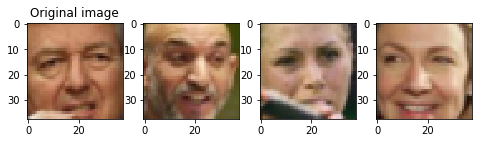

In [0]:
show_similar(X_test_tensor_n[1000])

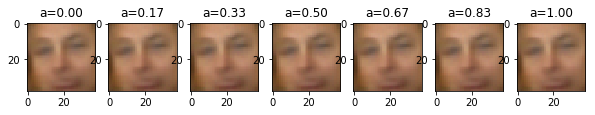

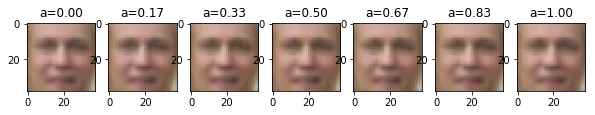

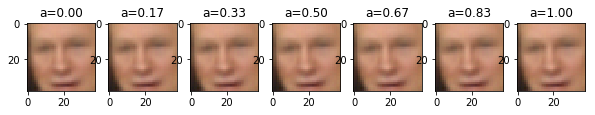

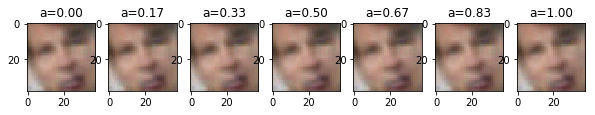

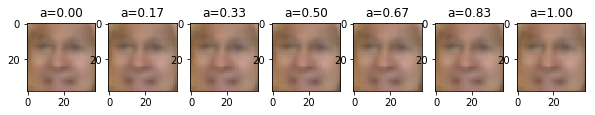

In [0]:
import random

for _ in range(5):
    code1, code2 = codes[random.randint(1, len(codes))], codes[random.randint(1, len(codes))]
    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):
        output_code = (code1 + code2) / 2
        output_image = aenc_deep.dec(torch.from_numpy(output_code[None]).type(torch.DoubleTensor).cuda())[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()